In [1]:
# Standard imports:
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import healpy as hp
import astropy.units as u
from astropy.coordinates import SkyCoord
import astropy.units as u

import glob as glob
import os

from astropy.coordinates import Angle
import lsst.geom

In [2]:
afwDisplay.setDefaultBackend('matplotlib')
from lsst.rsp import get_tap_service
service = get_tap_service("tap")

In [3]:
# Butler setup and skyMap retrieval:
collections = 'LSSTComCamSim/runs/DRP/OR4/w_2024_25/DM-45066'
butler = dafButler.Butler('embargo_or4', collections=collections)
registry = butler.registry
skyMap = butler.get('skyMap', dataId={'skymap':'ops_rehersal_prep_2k_v1'})

In [44]:
# select a tract and patch
for i, dt in enumerate(registry.queryDatasets(datasetType='goodSeeingCoadd', collections=collections)):
    # print(dt.dataId['tract'])
    if 150 < i < 200:
        print(dt.dataId)

{band: 'r', skymap: 'ops_rehersal_prep_2k_v1', tract: 2494, patch: 228}
{band: 'g', skymap: 'ops_rehersal_prep_2k_v1', tract: 2494, patch: 238}
{band: 'i', skymap: 'ops_rehersal_prep_2k_v1', tract: 2494, patch: 238}
{band: 'r', skymap: 'ops_rehersal_prep_2k_v1', tract: 2494, patch: 238}
{band: 'g', skymap: 'ops_rehersal_prep_2k_v1', tract: 2494, patch: 239}
{band: 'i', skymap: 'ops_rehersal_prep_2k_v1', tract: 2494, patch: 239}
{band: 'r', skymap: 'ops_rehersal_prep_2k_v1', tract: 2494, patch: 239}
{band: 'g', skymap: 'ops_rehersal_prep_2k_v1', tract: 2494, patch: 240}
{band: 'i', skymap: 'ops_rehersal_prep_2k_v1', tract: 2494, patch: 240}
{band: 'r', skymap: 'ops_rehersal_prep_2k_v1', tract: 2494, patch: 240}
{band: 'g', skymap: 'ops_rehersal_prep_2k_v1', tract: 2494, patch: 241}
{band: 'i', skymap: 'ops_rehersal_prep_2k_v1', tract: 2494, patch: 241}
{band: 'r', skymap: 'ops_rehersal_prep_2k_v1', tract: 2494, patch: 241}
{band: 'g', skymap: 'ops_rehersal_prep_2k_v1', tract: 2494, patc

In [4]:
# select_tract = 2494
# select_patch = 275
# select_tract = 2494
# select_patch = 155
# select_tract = 2494
# select_patch = 204
# select_tract = 2494
# select_patch = 138

In [47]:
class compare_static_truth_psf:
    def __init__(self, tract, patch):
        self.tract = tract
        self.patch = patch

    def get_objecttable(self):
        """
        Get objectTable for a tract and patch
        """
        tract_dataid = {'band': 'g', 'skymap': 'ops_rehersal_prep_2k_v1', 'tract': self.tract, 'patch': self.patch}
        obj_table = butler.get('objectTable', dataId=tract_dataid)
        obj_table = obj_table.reset_index()
        
        # select a bright object from g band 
        obj_table = obj_table[obj_table['refBand'] == 'g']
        obj_table = obj_table.sort_values('g_psfFlux', ascending=False)

        return obj_table
    
    # A funuction to determine the filename of a truthtable covering a DIA detecor image.
    def GetTruthFiles(self, RA, Dec):
        '''
        Given a set of coordinates, determine the filename of the pointsource parquet
        truth table that covers that region. This is needed because the parquet files
        are named according to the htm7 nside=32 region that they cover, so the index
        of the htm7 segment is needed to identify the file.
    
        Note
        ----
        This calculates the mean coordinate of the catalogue and uses that to
        determine the htm7 segment.
    
        Inputs
        ------
        RA: Pandas series containing the Right Ascention of sources in degrees.
        Dec: Pandas series containing the Deckination of sources in degrees.
    
        Outputs
        -------
        truthFiles: List of filenames of the truth table parquet files that cover the
                    region of interest.
        
        '''
        truthFiles = []
    
        mean_ra = np.deg2rad(np.mean(RA.value))
        mean_de = np.deg2rad(90. - np.mean(Dec.value))
        coordVec = hp.ang2vec(mean_de, mean_ra)
        ipix_discs = hp.query_disc(nside=32, vec=coordVec, radius=np.radians(2))
    
        for ipix_disc in ipix_discs:
            filename = '/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_{}.parquet'.format(ipix_disc)
            if os.path.exists(filename):
                truthFiles.append(filename)        
        return truthFiles

    def find_match_truth_objtable(self, truthFile_parquet, obj_table_df, obj_ra, obj_dec):
        truthTable = pd.read_parquet(truthFile_parquet)
        
        # select static sources
        truthTable = truthTable[truthTable['is_variable'] == False]
        truthTable = truthTable.sort_values('magnorm', ascending=True)
        truthTable = truthTable[(truthTable['magnorm'] > 17.0) & (truthTable['magnorm'] < 19.0)]
        
        # cross match with the object table
        trueCoords = SkyCoord(ra=truthTable['ra'].values*u.degree, dec=truthTable['dec'].values*u.degree)
        objCoords = SkyCoord(ra=obj_table_df['coord_ra'].values*u.degree, dec=obj_table_df['coord_dec'].values*u.degree)
        # objCoords = SkyCoord(ra=obj_ra*u.degree, dec=obj_dec*u.degree)
    
        idx, d2d, d3d = objCoords.match_to_catalog_sky(trueCoords) # idx is closest index in trueCoords
    
        # print('length of objCoords table: ',len(objCoords))
        # print('length of indices: ',len(idx))
    
        # select closest matche within 2"
        d2d_inx = np.where(d2d < 2*u.arcsec)
        idx = idx[d2d_inx]
        d2d = d2d[d2d_inx]
    
        return truthFile_parquet, idx

    def match_truth_forced(self, obj_table, obj_ra, obj_dec):
        # get truth files
        truthfile_match = 0
        idx_match = 0
        truthFiles = self.GetTruthFiles(obj_ra*u.degree, obj_dec*u.degree)
        
        for i, truthFile in enumerate(truthFiles):
            truthfile, idx = self.find_match_truth_objtable(truthFile, obj_table, obj_ra, obj_dec)
            print('matching indices: ',idx)
            if len(idx) != 0:
                truthfile_match = truthfile
                idx_match = idx[0]
                # print(truthfile_match)
                # print(idx_match)
                # get the truth table matched to object_table ra,dec
                truthTable = pd.read_parquet(str(truthfile_match))
                truthTable = truthTable[truthTable['is_variable'] == False]
                truthTable = truthTable.sort_values('magnorm', ascending=True)
                truthTable = truthTable[(truthTable['magnorm'] > 17.0) & (truthTable['magnorm'] < 19.0)]

                true_ra_list = []
                true_dec_list = []
                true_magnorm_list = []
                forced_ra_list = []
                forced_dec_list = []
                forced_band_list = []
                forced_mag_list = []
                tract_list = []
                patch_list = []

                for idx_match in idx:
                    true_magnorm = truthTable['magnorm'][idx_match:idx_match+1].values[0]
                    true_ra = truthTable['ra'][idx_match:idx_match+1].values[0]
                    true_dec = truthTable['dec'][idx_match:idx_match+1].values[0]
                
                    # get tract and patch for this true ra,dec
                    my_spherePoint = lsst.geom.SpherePoint(true_ra*lsst.geom.degrees,
                                                           true_dec*lsst.geom.degrees)    
                    tract = skyMap.findTract(my_spherePoint)
                    patch = tract.findPatch(my_spherePoint)
                    my_tract = tract.tract_id
                    my_patch = patch.getSequentialIndex()
                
                    # match the true ra,dec to forcedSourceTable ra,dec 
                    STable = butler.get('forcedSourceTable', tract=my_tract, patch=my_patch, skymap = 'ops_rehersal_prep_2k_v1')
                    trueCoords = SkyCoord(ra=true_ra*u.degree, dec=true_dec*u.degree)
                    SCoords = SkyCoord(ra=STable['coord_ra'].values*u.degree, dec=STable['coord_dec'].values*u.degree)
                    idx, d2d, d3d = trueCoords.match_to_catalog_sky(SCoords) #idx is closest index in SCoords
                    forced_ra = STable[int(idx):int(idx+1)]['coord_ra'].values[0]
                    forced_dec = STable[int(idx):int(idx+1)]['coord_dec'].values[0]
                    forced_band = STable[int(idx):int(idx+1)]['band'].values[0]
                    forced_flux = STable[int(idx):int(idx+1)]['psfFlux']
                    forced_mag = (forced_flux.to_numpy()*u.nJy).to(u.ABmag).value[0]

                    true_ra_list.append(true_ra)
                    true_dec_list.append(true_dec)
                    true_magnorm_list.append(true_magnorm)
                    forced_ra_list.append(forced_ra)
                    forced_dec_list.append(forced_dec)
                    forced_band_list.append(forced_band)
                    forced_mag_list.append(forced_mag)
                    tract_list.append(my_tract)
                    patch_list.append(my_patch)
    
                return true_ra_list, true_dec_list, true_magnorm_list, forced_ra_list, forced_dec_list, forced_band_list, forced_mag_list, tract_list, patch_list
            else:
                i+=1
        return 

In [48]:
truth_forced_dict = {'tract':[], 'patch':[], 'true_ra':[], 'true_dec':[], 'true_magnorm':[], 'forced_ra':[], 'forced_dec':[], 'forced_band':[], 'forced_mag':[]}
tracts = [2494, 2494, 2494, 2494, 2494, 2494, 2494, 2494]
patches = [192, 275, 155, 204, 138, 226, 255, 119]
# tracts = [2494]
# patches = [240]
n_sources = 1
for i in range(0, len(tracts)):
    select_tract = tracts[i]
    select_patch = patches[i]
    # print(select_tract, select_patch)
    compare_flux = compare_static_truth_psf(select_tract , select_patch)
    obj_table = compare_flux.get_objecttable()
    for j in range(0, n_sources):
        # obj_ra = obj_table.iloc[0]['coord_ra'] # select the brightes object from ObjectTable
        # obj_dec = obj_table.iloc[0]['coord_dec']
        obj_ra = obj_table.iloc[i]['coord_ra'] # select the brightes object from ObjectTable
        obj_dec = obj_table.iloc[i]['coord_dec']
        try:
            true_ra, true_dec, true_magnorm, forced_ra, forced_dec, forced_band, forced_mag, true_tract, true_patch = compare_flux.match_truth_forced(obj_table, obj_ra, obj_dec)
            truth_forced_dict['true_ra'].append(true_ra)
            truth_forced_dict['true_dec'].append(true_dec)
            truth_forced_dict['true_magnorm'].append(true_magnorm)
            truth_forced_dict['forced_ra'].append(forced_ra)
            truth_forced_dict['forced_dec'].append(forced_dec)
            truth_forced_dict['forced_band'].append(forced_band)
            truth_forced_dict['forced_mag'].append(forced_mag)
            truth_forced_dict['tract'].append(true_tract)
            truth_forced_dict['patch'].append(true_patch)
        except:
            continue


matching indices:  []
matching indices:  [14080 65583 23119]
matching indices:  []
matching indices:  [65522]
matching indices:  []
matching indices:  []
matching indices:  []
matching indices:  [31061]
matching indices:  [25270 17527 34605 42501 45882 50903 51391 54602]
matching indices:  []
matching indices:  []
matching indices:  []
matching indices:  [36046 36046]
matching indices:  []
matching indices:  [39199]
matching indices:  [15929 44735 40846]
matching indices:  []
matching indices:  []
matching indices:  [13323 21854 31686 32336 39076 39185 45107]


/opt/lsst/software/stack/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


In [49]:
# Flatten the lists
truth_forced_dict_flatten = {
    'true_ra': [item for sublist in truth_forced_dict['true_ra'] for item in sublist],
    'true_dec': [item for sublist in truth_forced_dict['true_dec'] for item in sublist],
    'true_magnorm': [item for sublist in truth_forced_dict['true_magnorm'] for item in sublist],
    'forced_ra': [item for sublist in truth_forced_dict['forced_ra'] for item in sublist],
    'forced_dec': [item for sublist in truth_forced_dict['forced_dec'] for item in sublist],
    'forced_band': [item for sublist in truth_forced_dict['forced_band'] for item in sublist],
    'forced_mag': [item for sublist in truth_forced_dict['forced_mag'] for item in sublist],
    'tract': [item for sublist in truth_forced_dict['tract'] for item in sublist],
    'patch': [item for sublist in truth_forced_dict['patch'] for item in sublist],
}

In [50]:
# truth_forced_dict_flatten

In [51]:
# Create the DataFrame
match_df = pd.DataFrame(truth_forced_dict_flatten)
match_df = match_df.dropna()
match_df['diff_mag'] = match_df['true_magnorm'] - match_df['forced_mag']

In [63]:
match_df = match_df.sort_values(by=['patch'])
match_df

,true_ra,true_dec,true_magnorm,forced_ra,forced_dec,forced_band,forced_mag,tract,patch,diff_mag
23,279.847380,-48.488530,18.635012,279.847385,-48.488521,i,18.249457,2494,102,0.385555
21,279.802394,-48.487408,18.401635,279.802394,-48.487409,r,18.412511,2494,103,-0.010876
25,279.830117,-48.474226,18.808789,279.830116,-48.474224,g,19.084659,2494,119,-0.275870
22,279.822484,-48.421050,18.421911,279.822484,-48.421049,i,18.124442,2494,119,0.297469
24,279.835420,-48.439019,18.638670,279.835418,-48.439018,r,18.585654,2494,119,0.053016
20,279.945289,-48.439794,18.053630,279.941122,-48.439642,i,26.054701,2495,134,-8.001070
14,279.613012,-48.342241,18.395048,279.613090,-48.342289,r,15.387353,2494,138,3.007695
13,279.613012,-48.342241,18.395048,279.613090,-48.342289,r,15.387353,2494,138,3.007695
4,279.536322,-48.309782,18.244831,279.536322,-48.309782,g,18.511057,2494,139,-0.266226
8,279.812197,-48.023234,18.569041,279.810360,-48.023578,g,24.690541,2494,187,-6.121500


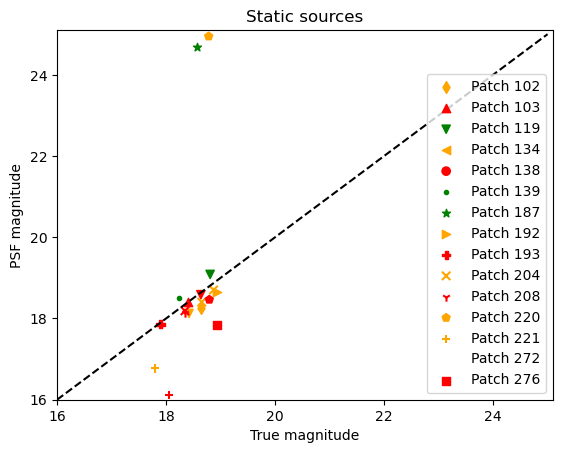

In [65]:
colors = {'r': 'red', 'g': 'green', 'i':'orange'}
markers= {102: 'd', 103: '^', 119:'v', 134: '<', 138: 'o', 139: '.', 187: '*', 192: '>', 193:'P', 204: 'x', 208: '1', 220:'p', 221:'+', 272: '', 276:'s'}
for marker_value, marker_style in markers.items():
    subset = match_df[match_df['patch'] == marker_value]
    plt.scatter(subset['true_magnorm'], subset['forced_mag'], 
                c=subset['forced_band'].map(colors), marker=marker_style, label=f'Patch {marker_value}')

plt.plot([16.0, 25.0], [16.0, 25.0], ls='--', color='k')
plt.xlabel('True magnitude')
plt.ylabel('PSF magnitude')
plt.title('Static sources')
#set limits
plt.xlim(16.0, 25.1)
plt.ylim(16.0, 25.1)

plt.legend(loc='lower right')
plt.show()

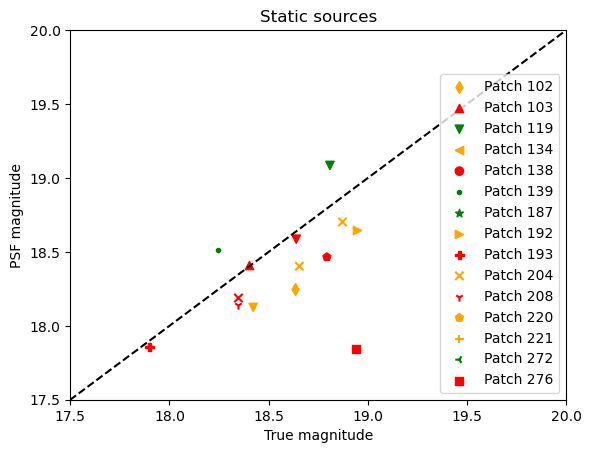

In [66]:
colors = {'r': 'red', 'g': 'green', 'i':'orange'}
markers= {102: 'd', 103: '^', 119:'v', 134: '<', 138: 'o', 139: '.', 187: '*', 192: '>', 193:'P', 204: 'x', 208: '1', 220:'p', 221:'+', 272: '3', 276:'s'}
for marker_value, marker_style in markers.items():
    subset = match_df[match_df['patch'] == marker_value]
    plt.scatter(subset['true_magnorm'], subset['forced_mag'], 
                c=subset['forced_band'].map(colors), marker=marker_style, label=f'Patch {marker_value}')

plt.plot([16.0, 25.0], [16.0, 25.0], ls='--', color='k')
plt.xlabel('True magnitude')
plt.ylabel('PSF magnitude')
plt.title('Static sources')
#set limits
plt.xlim(17.5, 20.0)
plt.ylim(17.5, 20.0)

plt.legend(loc='lower right')
plt.show()

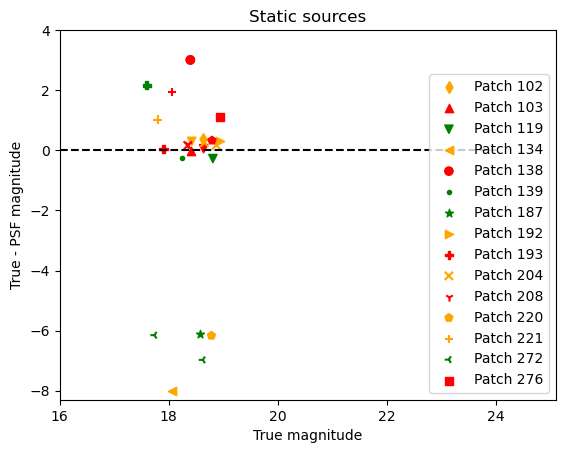

In [70]:
colors = {'r': 'red', 'g': 'green', 'i':'orange'}
markers= {102: 'd', 103: '^', 119:'v', 134: '<', 138: 'o', 139: '.', 187: '*', 192: '>', 193:'P', 204: 'x', 208: '1', 220:'p', 221:'+', 272: '3', 276:'s'}
for marker_value, marker_style in markers.items():
    subset = match_df[match_df['patch'] == marker_value]
    plt.scatter(subset['true_magnorm'], subset['diff_mag'], 
                c=subset['forced_band'].map(colors), marker=marker_style, label=f'Patch {marker_value}')

plt.plot([16.0, 24.0], [0.0, 0.0], ls='--', color='k')
plt.xlabel('True magnitude')
plt.ylabel('True - PSF magnitude')
plt.title('Static sources')
#set limits
plt.xlim(16.0, 25.1)
plt.ylim(-8.3, 4.0)

plt.legend(loc='lower right')
plt.show()

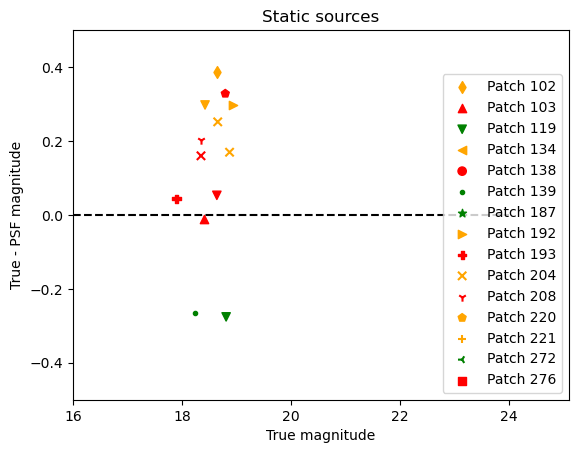

In [69]:
colors = {'r': 'red', 'g': 'green', 'i':'orange'}
markers= {102: 'd', 103: '^', 119:'v', 134: '<', 138: 'o', 139: '.', 187: '*', 192: '>', 193:'P', 204: 'x', 208: '1', 220:'p', 221:'+', 272: '3', 276:'s'}
for marker_value, marker_style in markers.items():
    subset = match_df[match_df['patch'] == marker_value]
    plt.scatter(subset['true_magnorm'], subset['diff_mag'], 
                c=subset['forced_band'].map(colors), marker=marker_style, label=f'Patch {marker_value}')

plt.plot([16.0, 24.0], [0.0, 0.0], ls='--', color='k')
plt.xlabel('True magnitude')
plt.ylabel('True - PSF magnitude')
plt.title('Static sources')
#set limits
plt.xlim(16.0, 25.1)
plt.ylim(-0.5, 0.5)

plt.legend(loc='lower right')
plt.show()